# Analyzing SOFC data (part 4)

## 4) Quantitative features
I began by analyzing electron affinity and d-electron count, which do appear to capture most of the variability. I also looked at ion radius, which appeared to have no effect. However, there are other features to consider and it may be worth revisiting the radii with a better model (built in part 2). I have found that the categorical features have no effect on model performance (part 3), so I will remain with quantitative features only.

###Average vs parent features:
I should mention here that there are **two sets of features** in my data set. One, which is marked with an 'avg' prefix, corresponds to the average factor taking into account dopant ions in the material. For example, La_0.5 Sr_0.5 Ni O_3 would have an A-site radius of 0.5\*La + 0.5\*Sr. The parent ion in this material is lanthanum (for reasons that are beyond the scope of this analysis), so the parent A-site radius is simply 1\*La.

Until now, I have only considered the average set of features, as I suspected it would be more descriptive. In this notebook I will test that hypothesis as well as determine the most descriptive features within each set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import pandas as pd
import time
%matplotlib inline
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE

from sofc_func import *

In [2]:
# Import using pandas
df = pd.read_csv("data.csv")

# Clean out rows where there is no parent A or parent B

data = df[pd.notnull(df['A_par']) & pd.notnull(df['B_par']) & pd.notnull(df['d_star']) & pd.notnull(df['k_star']) 
             & pd.notnull(df['e affinity(B)']) & pd.notnull(df['d-electron count (B)'])]

pd.options.mode.chained_assignment = None

data = features(df)

data['dk_star'] = pd.Series(dk_star(data,1000), index=df.index)

In [3]:
f = df[pd.notnull(data['EA_A']) & pd.notnull(data['EA_B']) & pd.notnull(data['r_A'])
          & pd.notnull(data['r_B']) & pd.notnull(data['d_count_B']) & pd.notnull(data['avg_EA_A'])
          & pd.notnull(data['avg_EA_B']) & pd.notnull(data['avg_r_A']) & pd.notnull(data['avg_r_B'])
          & pd.notnull(data['avg_d_count_B']) & pd.notnull(data['dk_star'])]
X = f[ ['EA_A', 'EA_B', 'r_A', 'r_B', 'd_count_B', 'avg_EA_A', 'avg_EA_B', 'avg_r_A',
        'avg_r_B', 'avg_d_count_B' ]]

y = f['dk_star']

In [4]:
#model = make_pipeline(PolynomialFeatures(3), Ridge())
model = Ridge().fit(X,y)
selector = RFE(model, 1, step=1)
selector = selector.fit(X, y)

rank = []

for i, v in enumerate(X.columns.values):
    rank.append([v, int(selector.ranking_[i]) ] )
    #print v, selector.ranking_[i]
rank = np.array(rank)
print rank

[['EA_A' '7']
 ['EA_B' '4']
 ['r_A' '9']
 ['r_B' '1']
 ['d_count_B' '6']
 ['avg_EA_A' '8']
 ['avg_EA_B' '2']
 ['avg_r_A' '10']
 ['avg_r_B' '3']
 ['avg_d_count_B' '5']]


The top 6 most important features are:
**r_B , avg_EA_B, avg_r_b, EA_B, avg_d_count_B, d_count_B**

I will plot these features against D\*k\* and take a look at what model might represent them.

[]

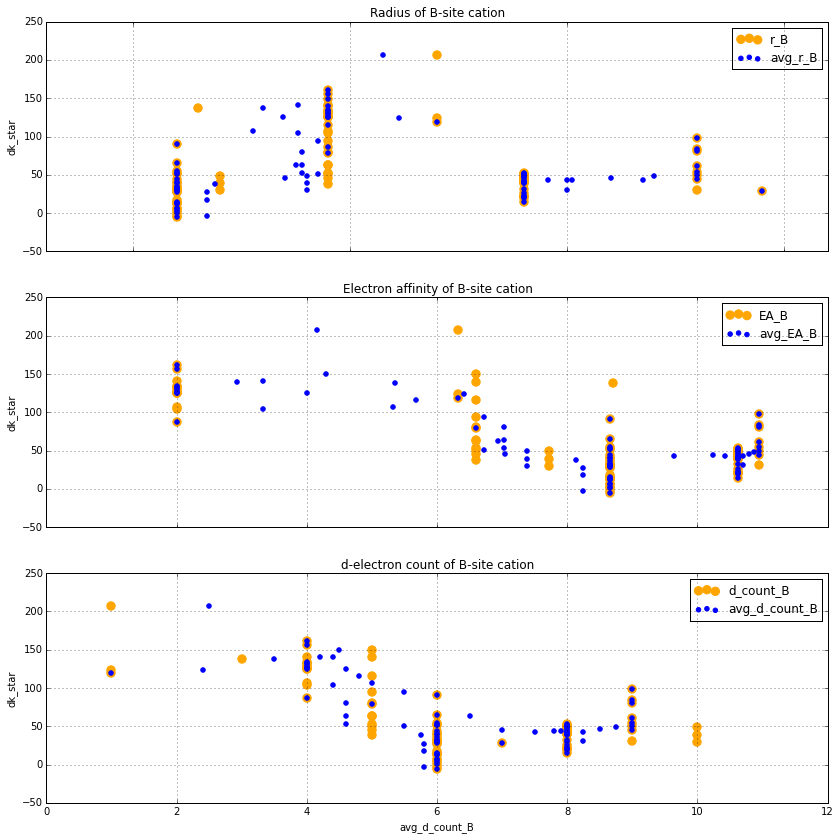

In [5]:
fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)
plt.title('Radius of B-site cation')
f.plot(kind='scatter', x='r_B', y='dk_star', label='r_B', color='orange', s=70, ax=ax1)
f.plot(kind='scatter', x='avg_r_B', y='dk_star', label='avg_r_B', color='blue', ax=ax1)

ax2 = plt.subplot2grid((3,3), (1,0), colspan=3)
plt.title('Electron affinity of B-site cation')
f.plot(kind='scatter', x='EA_B', y='dk_star', label='EA_B', color='orange', s=70, ax=ax2)
f.plot(kind='scatter', x='avg_EA_B', y='dk_star', label='avg_EA_B', color='blue', ax=ax2)

ax3 = plt.subplot2grid((3,3), (2,0), colspan=3)
plt.title('d-electron count of B-site cation')
plt.xlabel('d-electron count')
#plt.ylabel('D\*k\*')
f.plot(kind='scatter', x='d_count_B', y='dk_star', label='d_count_B', color='orange', s=70, ax=ax3)
f.plot(kind='scatter', x='avg_d_count_B', y='dk_star', label='avg_d_count_B', color='blue', ax=ax3)

plt.plot()

These are the three main factors to consider: **r_B, EA_B, and d_count_B**. This suggests the values of D\*k\* are driven primarily by the choice of B-cation. A further differentiation should be made between the average values and the pure values. Average values take into account dopant, or mixed cation concentrations. In all three plots, the average values appear to follow the same trends as the pure values, with more information provided between pure values, which are not continuous in any of these factors. A small exception may be given to radius of the B-site cation, which has a lot of variance for smaller cations and appears to be a less reliable descriptor of the diffusivity measurements.

###Average or parent factors?
One consideration is to determine how well a model can represent variation if it uses average or pure values of the factors. I will construct two models with the three above factors and determine which one is better.

###Parent factors:

In [23]:
import time
pure_x = np.array(X[['r_B', 'EA_B', 'd_count_B']])
pure_y = np.array([y]).T

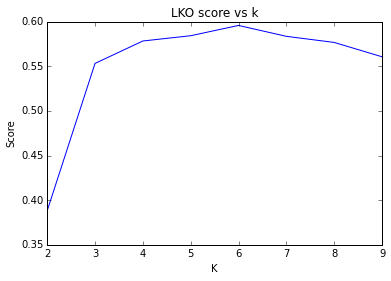

k optmization executed in: 48.769211s


In [12]:
optimize_k(1000, len(pure_y), pure_x, pure_y)

I did 1000 iterations because there was variability even at several hundred cycles.

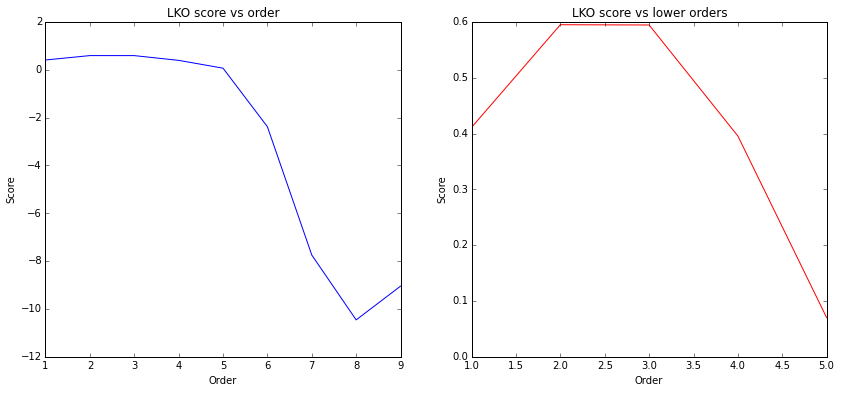

Polynomial order optimization executed in: 79.991863s


In [15]:
optimize_order(500, len(pure_y), 6, pure_x, pure_y)

2nd and 3rd order polynomials appear to have almost exactly the same score.

###Average model:

In [16]:
avg_x = np.array(X[['avg_r_B', 'avg_EA_B', 'avg_d_count_B']])
avg_y = np.array([y]).T

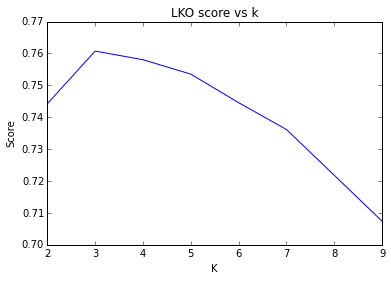

k optmization executed in: 46.93621s


In [18]:
optimize_k(1000, len(avg_y), avg_x, avg_y)

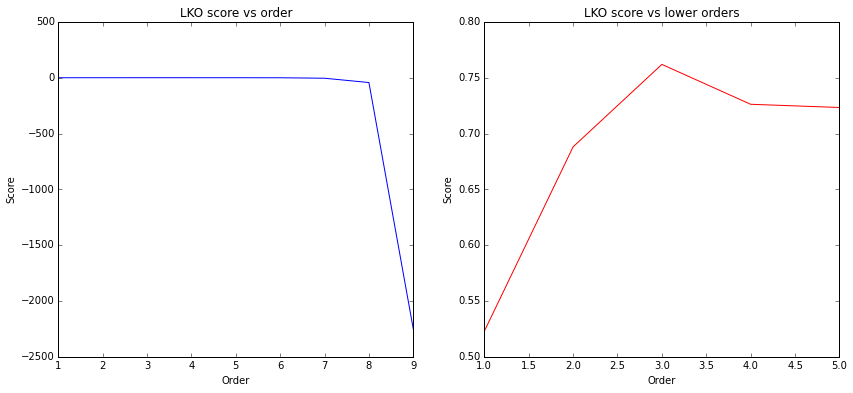

Polynomial order optimization executed in: 33.865017s


In [19]:
optimize_order(500, len(avg_y), 3, avg_x, avg_y)

###Comparison between pure and average models:

####Pure model score:

In [21]:
get_scores(1000, 6,3,len(pure_y),pure_x,pure_y)

Average score of this model: 0.600431300874
Standard deviation of scores: 0.177412722207


####Average model score:

In [22]:
get_scores(1000, 3,3,len(avg_y),avg_x,avg_y)

Average score of this model: 0.760081458772
Standard deviation of scores: 0.0326283240654


##Conclusion:

From this, we can see that the scores of the average model are much higher and with a much lower standard deviation. This is a somewhat obvious result given the scatterplots above because **there is more average data and both pure and average data have the same shape for a given category**. Nonetheless, this is a good sanity check. Coupled with the fact that these features are the most descriptive ones, it would appear that this is the best model to use to describe our data.

The **next notebook** will proceed to ensure that:

**1)** These three parameters individually contribute to a fair portion of the variation (i.e. there is not overwhelming multicollinearity between them - I know there will be some)

**2)** The parameters I left out (i.e. the ones corresponding to the A-cation) don't explain very much variation and are correctly left from the model.

I should note that by choosing to remove 3 of these parameters (the pure ones), I am somewhat disregarding what the recursive feature elimination (RFE) told me at the beginning. I am doing this because there is obviously a huge amount of multicollinearity associated with, for example, average radius and parent radius.